# 1 개인 활동으로 이탈 예측

* 1. 전처리한 데이터 불러오기

In [2]:
import pandas as pd
df = pd.read_csv("c:/vscode/미니프로젝트/2_분류_프로젝트/data/activity_sum.csv")
df.head(2)

,acc_id,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count,survive
0,2,91.533663,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,84.900753,-0.008746,0.0,1
1,5,6.116132,3.236452,2.155434,0.695285,0.111055,9,0.245883,0.247337,0.0,3.442909,0.000000,0.145146,0.0,0


* 2. 변수 선택

In [5]:
train_cols=df.columns[1:14] #0~18
X=df[train_cols] #독립변수
y=df['survive'] #종속변수

In [7]:
#로지스틱 회귀분석
import statsmodels.api as sm

model=sm.Logit(y,X) #로지스틱 회귀분석 모형
result=model.fit()
print(result.summary2()) # 요약정보
#모형의 설명력 : 13.7%
#유의하지 않은 변수들 : 'game_money_change'

Optimization terminated successfully.
         Current function value: 0.593756
         Iterations 6
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.137     
Dependent Variable:  survive          AIC:              47526.4688
Date:                2023-04-21 12:28 BIC:              47638.2251
No. Observations:    40000            Log-Likelihood:   -23750.   
Df Model:            12               LL-Null:          -27526.   
Df Residuals:        39987            LLR p-value:      0.0000    
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      6.0000                                       
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
playtime          -0.0057   0.0006 -10.1672 0.0000 -0.0068 -0.0046
npc_kill           0.0157   0.0007  22.2661 0.0000  0

In [8]:
train_cols

Index(['playtime', 'npc_kill', 'solo_exp', 'party_exp', 'quest_exp',
       'rich_monster', 'death', 'revive', 'exp_recovery', 'fishing',
       'private_shop', 'game_money_change', 'enchant_count'],
      dtype='object')

In [9]:
#후진제거법
#최종적으로 선택한 독립변수
train_cols = ['playtime', 'npc_kill', 'solo_exp', 'party_exp', 'quest_exp',
            'rich_monster', 'death', 'revive', 'exp_recovery', 'fishing',
            'private_shop', 'enchant_count']

df['survive'].value_counts() #샘플링 전의 0,1 분포

1    21996
0    18004
Name: survive, dtype: int64

* 3. 언더샘플링

In [10]:
from imblearn.under_sampling import RandomUnderSampler

X_sample,y_sample = RandomUnderSampler(random_state=0).fit_resample(X,y)
X_samp=pd.DataFrame(data=X_sample,columns=train_cols)
y_samp=pd.DataFrame(data=y_sample,columns=['survive'])
df_samp=pd.concat([X_samp,y_samp],axis=1)
df_samp['survive'].value_counts() #샘플링 후의 0,1 분포

0    18004
1    18004
Name: survive, dtype: int64

In [11]:
#샘플링 데이터셋에서 X,y 선택
X = X_samp[train_cols]
y = y_samp['survive']

* 4. 알고리즘별 비교

In [12]:
#다양한 알고리즘별 정확도를 저장할 리스트
scores = []

In [13]:
# 1) 로지스틱 회귀분석
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=0)),
])
params = {
    'clf__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100],
}
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

scores.append(grid.best_score_)

{'clf__C': 100}
0.6985114661178065


In [15]:
# 2) 의사결정나무
from sklearn.tree import DecisionTreeClassifier

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=0)),
])
params = {
    'clf__max_depth': list(range(3,6))
}
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

scores.append(grid.best_score_)

{'clf__max_depth': 5}
0.6927626186548959


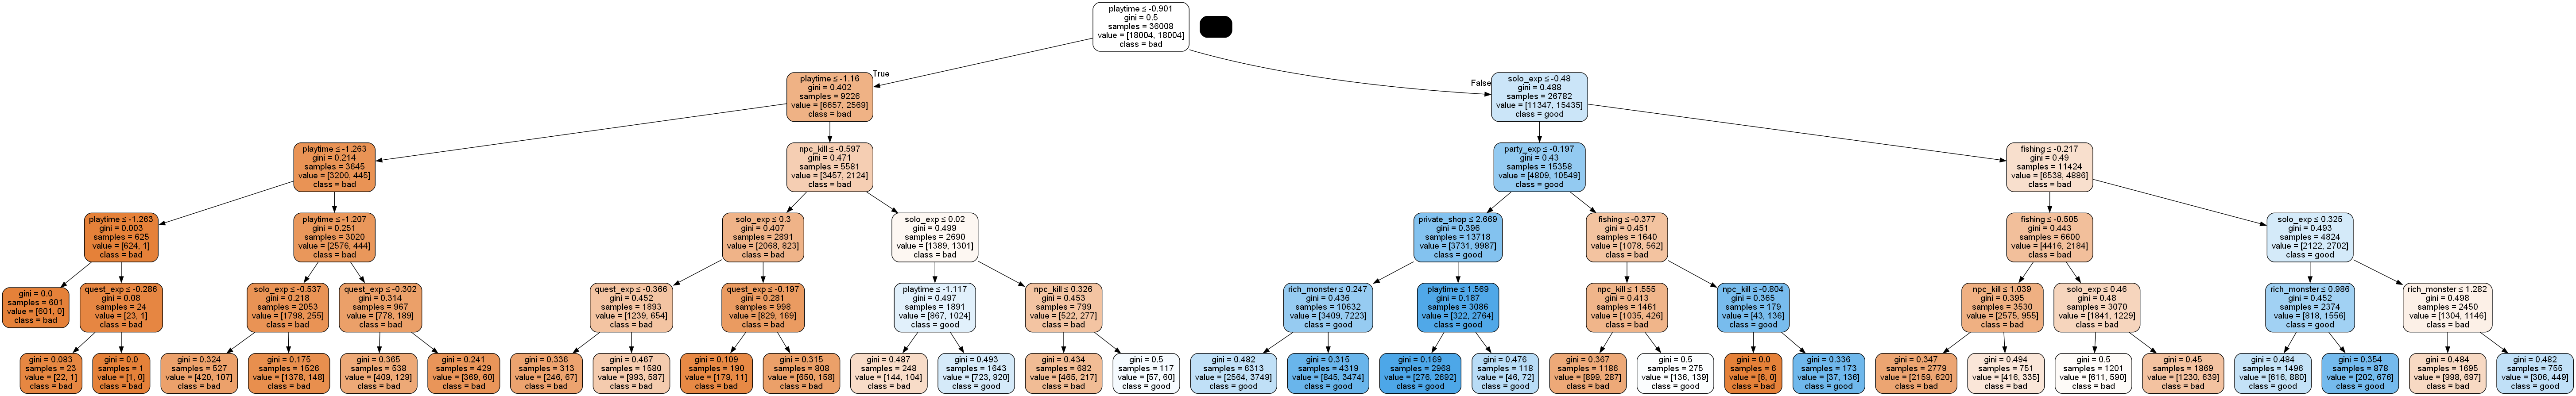

In [16]:
# 2-2) 특성중요도
from sklearn.tree import export_graphviz
import pydotplus
import graphviz
from IPython.display import Image

tree=grid.best_estimator_['clf']
dot_data = export_graphviz(tree, out_file=None,
        feature_names=train_cols, class_names=["bad","good"],
filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

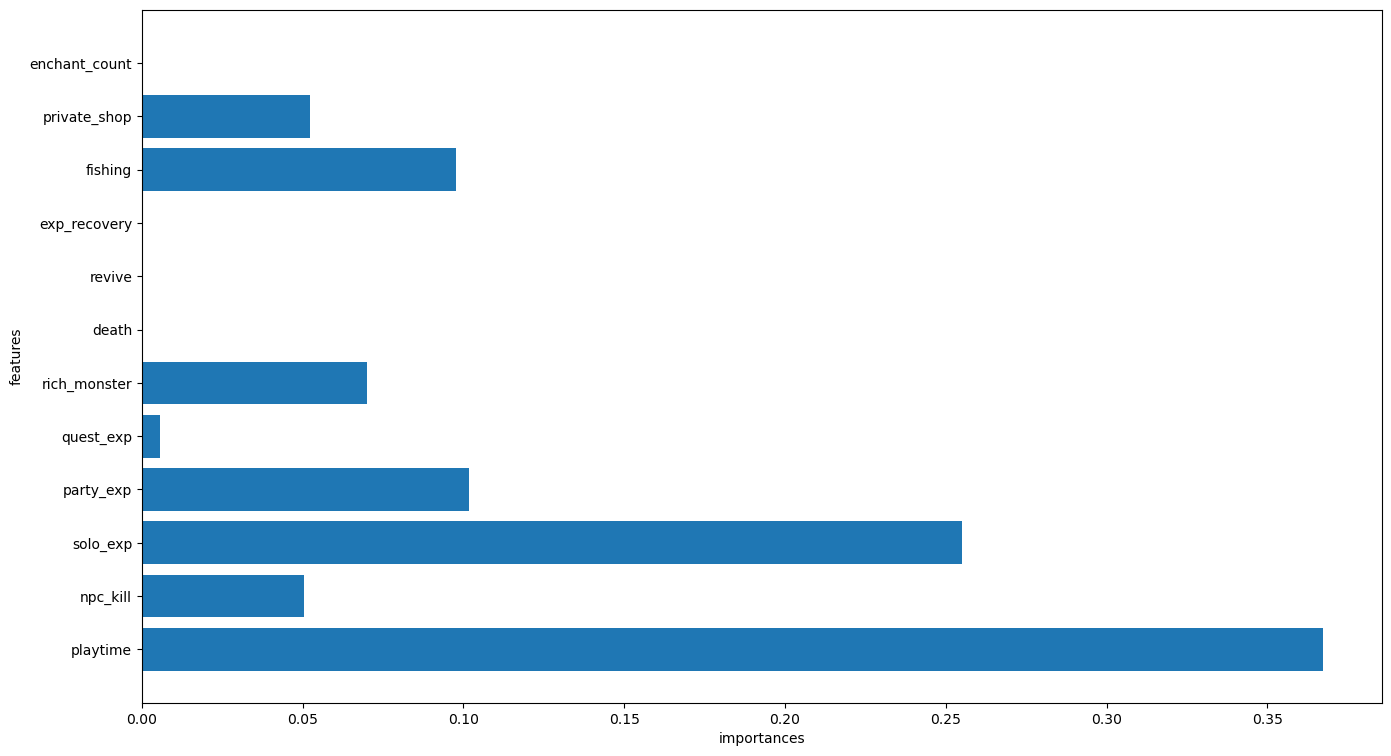

In [17]:
# 2-2) 특성중요도
import numpy as np
import matplotlib.pyplot as plt

def plot_tree(model):
    n_features = X.shape[1]
    plt.rcParams["figure.figsize"]=(16,9)
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train_cols)
    plt.xlabel("importances")
    plt.ylabel("features")
    plt.ylim(-1, n_features)
plot_tree(tree)

In [ ]:
# 중요도 높은 변수 : playtime, solo_exp, party_exp, fishing, rich_monster

In [18]:
# 3) 랜덤포레스트
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=0)),
])
params = {
    'clf__max_depth': list(range(3,6)),
    'clf__n_estimators': list(range(10,110,10)),
}
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

scores.append(grid.best_score_)

{'clf__max_depth': 5, 'clf__n_estimators': 30}
0.7139525247555523


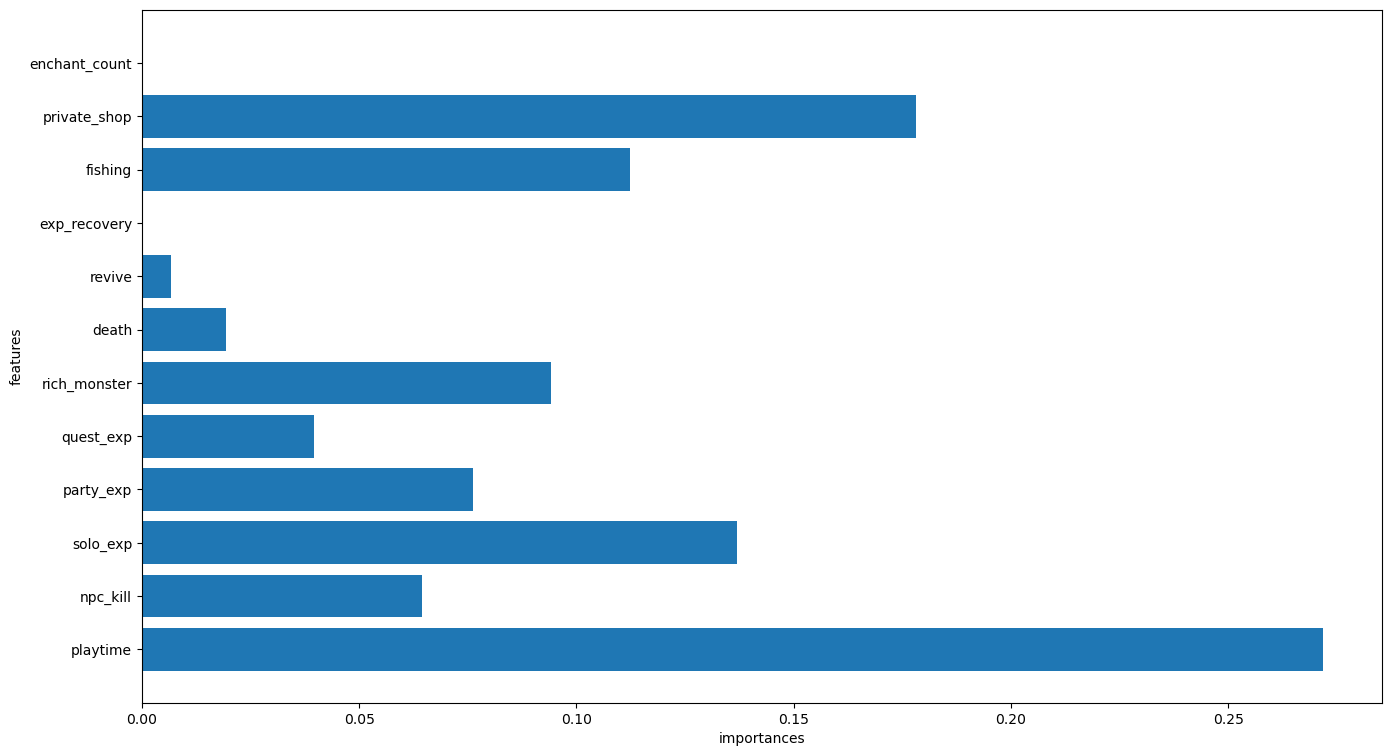

In [19]:
# 3-2) 특성중요도
rf=grid.best_estimator_['clf']
plot_tree(rf)
# # 중요도 높은 변수 : playtime, private_shop, solo_exp, fishing, rich_monster

In [20]:
# 4) knn
from sklearn.neighbors import KNeighborsClassifier

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier()),
])
params = {
    'clf__n_neighbors': list(range(1,6)),
}
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

scores.append(grid.best_score_)

c:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to a

{'clf__n_neighbors': 5}
0.7042323692068521


In [21]:
# 5) 인공신경망
from sklearn.neural_network import MLPClassifier

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MLPClassifier(random_state=0, max_iter=5000)),
])
params = {
    'clf__hidden_layer_sizes': [(50,), (100,)],
}
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

scores.append(grid.best_score_)

{'clf__hidden_layer_sizes': (50,)}
0.71475782806784


In [22]:
# 6) svm
from sklearn.svm import SVC

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(random_state=0)),
])
params = {
    'clf__C': [0.01, 0.1],
    'clf__gamma': [0.001, 0.01],
}
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

scores.append(grid.best_score_)

{'clf__C': 0.1, 'clf__gamma': 0.01}
0.7047323205951646


In [24]:
# 7) keras
from scikeras.wrappers import KerasClassifier
from keras import models
from keras import layers

def create_network(optimizer="rmsprop"):
    network = models.Sequential()
    network.add(layers.Dense(units=16, activation="relu",
    input_shape=(X.shape[1],)))
    # network.add(layers.Dense(units=16, activation="relu"))
    network.add(layers.Dense(units=1, activation="sigmoid"))
    network.compile(loss='binary_crossentropy',
                    optimizer=optimizer, # 옵티마이저
                    metrics=["accuracy"]) # 성능 지표
    return network

neural_network = KerasClassifier(model=create_network, verbose=0)
# 하이퍼파라미터 탐색 영역을 정의
pipe=Pipeline([
    ('scaler',StandardScaler()),
    ('clf',neural_network)
])
params={
    'clf__epochs': [50, 100],
    'clf__batch_size': [32,64],
    'clf__optimizer': ["rmsprop", "adam"],
}
grid=GridSearchCV(pipe,params,scoring='accuracy',cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

scores.append(grid.best_score_)

{'clf__batch_size': 32, 'clf__epochs': 50, 'clf__optimizer': 'rmsprop'}
0.7146189692647938


* 5. 알고리즘별 예측도 그래프

['LOGIT', 'Tree', 'RF', 'KNN', 'ANN', 'SVM', 'DNN']
[0.69851147 0.69276262 0.71395252 0.70423237 0.71475783 0.70473232
 0.71461897]
최적의 알고리즘: ANN
최적의 정확도: 0.71475782806784


Text(0, 0.5, 'Accuracy')

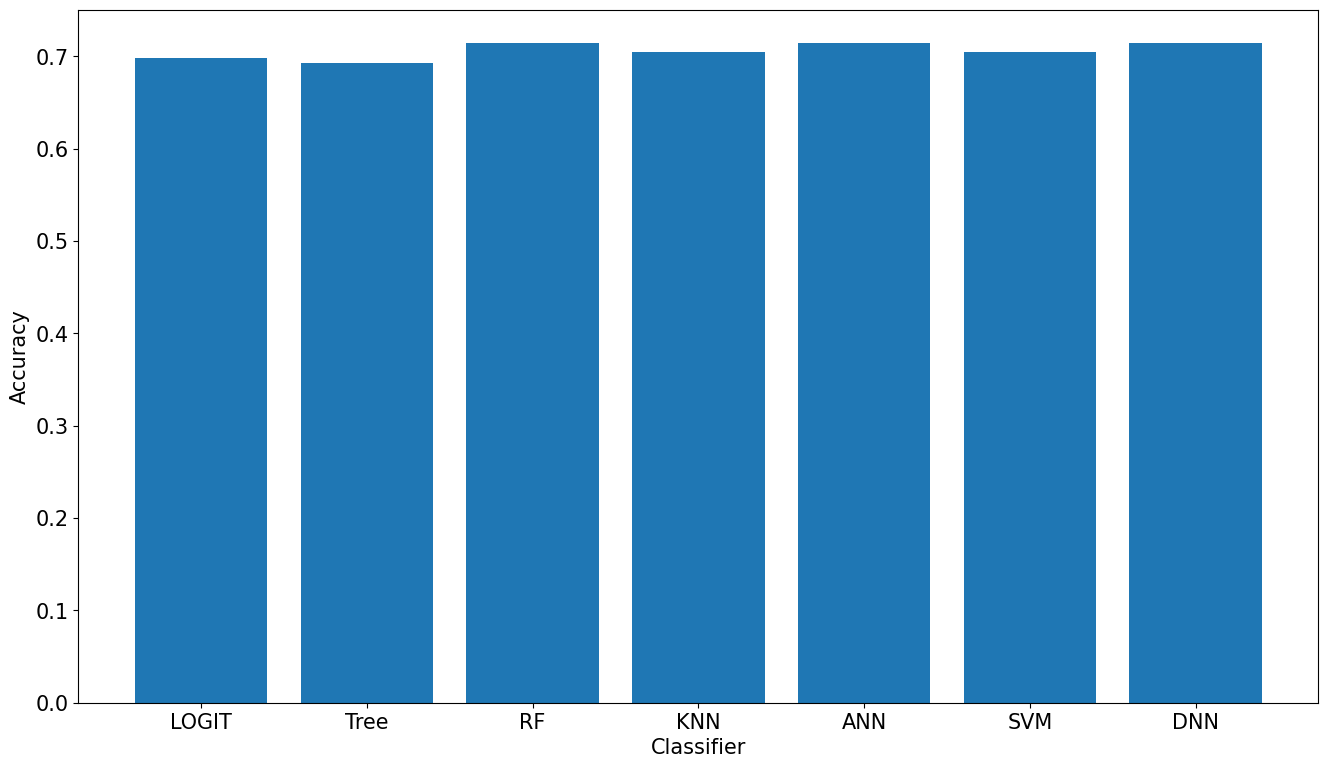

In [25]:
methods=["LOGIT","Tree","RF","KNN","ANN","SVM","DNN"]

scores_arr=np.array(scores) #검증용 데이터셋의 정확도
max_rate=np.max(scores_arr) #가장 좋은 정확도
idx=np.argmax(scores_arr) #최대값의 인덱스

print(methods)
print(scores_arr)
print("최적의 알고리즘:",methods[idx])
print("최적의 정확도:",max_rate)

plt.rcParams["font.size"]=15
plt.bar(methods, scores_arr)
plt.xlabel("Classifier")
plt.ylabel("Accuracy")